In [55]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 
print("hi")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hi


In [56]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [57]:
global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1" ,                 # Use CPU only/ Delete line when run on GPU
    verbosity = 3
)
#GRU 1st, GRU 2nd, and CNN LSTM for 2nd 

#add hyperp. tuning 

Num GPUs Available:  0


In [58]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False:       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot !
#False, True, False:        X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:        X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:         X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True:         X.shape = (4846500, 14), Y.shape = (4846500, 1) !!!!
#True, True, True:          X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True #stack series
cond2 = False #multiclass
cond3 = True #propogate output
#true f t is the !
#F F F is the !!!
fract = 0.2
#inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)
steping = 150
inputs, outputs = load_anomaly(input_path, output_path, cond1, cond2, cond3, fract, steping)

In [59]:
inputs.shape

(10260, 14)

In [60]:
outputs.shape

(10260, 1)

In [61]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (time steps: 10260, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * time steps  (time steps) int64 0 1 2 3 4 5 ... 10255 10256 10257 10258 10259
  * features    (features) object 'Class_Fault' 'Class_Run'

In [62]:
data = xr.concat([inputs, outputs], dim="features")
data.shape

(10260, 16)

In [63]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)


In [64]:
inputs.shape

(10251, 10, 14)

In [65]:
outputs.shape

(10251, 2)

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [67]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [68]:

xtrain.shape

(7175, 10, 14)

In [69]:
ytrain.shape

(7175, 2)

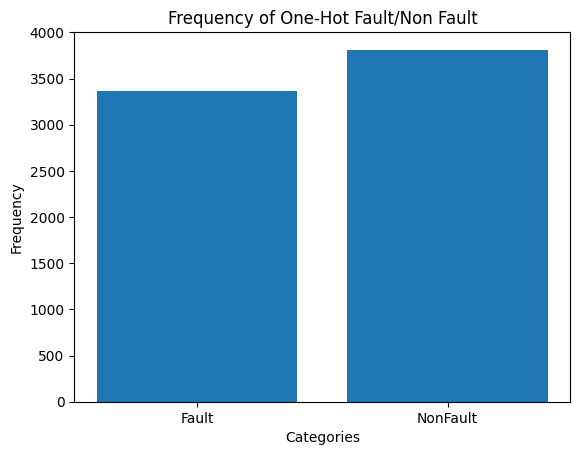

<xarray.DataArray (samples: 7175, features: 2)>
array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])
Coordinates:
  * samples   (samples) int64 9532 4720 4944 598 4267 ... 5873 5944 5415 10057
  * features  (features) object 'Class_Fault' 'Class_Run'

In [70]:
ytrain

frequency = np.sum(ytrain, axis=0)

# Categories
categories = ['Fault', 'NonFault']

# Plot
plt.bar(categories, frequency)
plt.title('Frequency of One-Hot Fault/Non Fault')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()
ytrain

In [71]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
    "GRU": {  # Adding GRU layer
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
    "Dense": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": mai.Int(min_value=25, max_value=250),
        "activation": "sigmoid",
        "kernel_initializer": "normal",
        "sublayer": mai.Choice(["Dropout_hidden", "None"]),
        "Dropout_hidden": {
            "rate": mai.Float(min_value=0.4, max_value=0.6),
        },
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}

fitting = {
    "batch_size": 128,
    "epochs": 5,
    "validation_split": 0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}

adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
}

compiling = {
    "loss": "binary_crossentropy",
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM", "GRU"],  # Add GRU to models list
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
    "GRU": {  # Define GRU model settings
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}

tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)


In [72]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=10,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 10 Complete [00h 01m 26s]
accuracy_score: 0.5467595818815332

Best accuracy_score So Far: 0.72
Total elapsed time: 00h 08m 20s

Top Configurations

-- LSTM | Training Time: 00:08:19
LSTM_num_layers: 0
GRU_num_layers: 1
Dense_num_layers: 2
Adam_learning_rate: 0.0006042769577505358
Dense_0_units: 230
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.5005378477509896
Dense_1_units: 89
Dense_1_sublayer: None
Dense_1_sublayer_Dropout_hidden_0_rate: 0.45473645573058513

-- GRU | Training Time: 00:08:19
LSTM_num_layers: 0
GRU_num_layers: 2
Dense_num_layers: 0
Adam_learning_rate: 0.0002472814226482861
Dense_0_units: 242
Dense_0_sublayer: None
Dense_0_sublayer_Dropout_hidden_0_rate: 0.5540130943687869
Hyperparameter tuning took 16.653332567214967 minutes to process.


In [73]:
xtrain

<xarray.DataArray (samples: 7175, time steps: 10, features: 14)>
array([[[0.85255891, 0.62051238, 0.83061396, ..., 0.33411239,
         0.81656122, 0.42682267],
        [0.83781512, 0.63389853, 0.81503776, ..., 0.47582992,
         0.816104  , 0.54178252],
        [0.82307119, 0.63155594, 0.81281248, ..., 0.49553947,
         0.81552913, 0.76058079],
        ...,
        [0.84041712, 0.62954805, 0.82082308, ..., 0.50867885,
         0.81633035, 0.52864536],
        [0.83608057, 0.62988269, 0.82171315, ..., 0.51055584,
         0.88414775, 0.56636122],
        [0.06244962, 0.63389853, 0.80702691, ..., 0.84842008,
         0.88449633, 0.61353105]],

       [[0.83174415, 0.10850377, 0.43944109, ..., 0.52228737,
         0.94721639, 0.5682731 ],
        [0.83651419, 0.35547455, 0.81726267, ..., 0.52604135,
         0.94540563, 0.58333334],
        [0.15093764, 0.63222525, 0.8212681 , ..., 0.51477926,
         0.94413808, 0.71902997],
...
        [0.83738149, 0.62318961, 0.85242051, ..., 0.33692625,
         0.91552814, 0.35897435],
        [0.83304501, 0.63389853, 0.80035144, ..., 0.47770738,
         0.91561871, 0.66064258],
        [0.83087668, 0.62921338, 0.80702691, ..., 0.49741646,
         0.91552814, 0.63422923]],

       [[0.8304433 , 0.41503648, 0.7309253 , ..., 0.51571768,
         0.39034979, 0.5060241 ],
        [0.83000956, 0.53517739, 0.79990632, ..., 0.51759482,
         0.39012345, 0.5663423 ],
        [0.7038191 , 0.60679178, 0.81325761, ..., 0.50774028,
         0.38965716, 0.61345382],
        ...,
        [0.69297745, 0.61248097, 0.81192223, ..., 0.50398615,
         0.38621221, 0.59275564],
        [0.60928504, 0.62385906, 0.8012417 , ..., 0.51102511,
         0.38506238, 0.53992895],
        [0.82090286, 0.49635673, 0.5168664 , ..., 0.50210916,
         0.38460516, 0.5796262 ]]])
Coordinates:
  * samples     (samples) int64 9532 4720 4944 598 4267 ... 5873 5944 5415 10057
  * time steps  (time steps) int64 0 1 2 3 4 5 6 7 8 9
  * features    (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [74]:
ytrain.shape

(7175, 2)

In [75]:
xtrain.shape

(7175, 10, 14)

In [76]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 100}},
    },
  #  y_scaler=y_scaler,
)

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 3ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 4ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 1ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 5ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 3ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 3ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 2ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [==============================] - 0s 3ms/step
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
97/97 [================

In [77]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
2,LSTM,"{'LSTM_num_layers': 0, 'GRU_num_layers': 0, 'D...",0.743275,0.743275,0.743275,0.743275,0.752926,0.752926,0.752926,0.752926
7,GRU,"{'LSTM_num_layers': 0, 'GRU_num_layers': 0, 'D...",0.743275,0.743275,0.743275,0.743275,0.750000,0.750000,0.750000,0.750000
4,LSTM,"{'LSTM_num_layers': 1, 'GRU_num_layers': 0, 'D...",0.739233,0.739233,0.739233,0.739233,0.748375,0.748375,0.748375,0.748375
5,GRU,"{'LSTM_num_layers': 0, 'GRU_num_layers': 2, 'D...",0.732125,0.732125,0.732125,0.732125,0.739922,0.739922,0.739922,0.739922
8,GRU,"{'LSTM_num_layers': 1, 'GRU_num_layers': 0, 'D...",0.723624,0.723624,0.723624,0.723624,0.734070,0.734070,0.734070,0.734070
6,GRU,"{'LSTM_num_layers': 0, 'GRU_num_layers': 1, 'D...",0.729617,0.729617,0.729617,0.729617,0.733095,0.733095,0.733095,0.733095
0,LSTM,"{'LSTM_num_layers': 0, 'GRU_num_layers': 1, 'D...",0.726551,0.726551,0.726551,0.726551,0.728869,0.728869,0.728869,0.728869
3,LSTM,"{'LSTM_num_layers': 3, 'GRU_num_layers': 0, 'D...",0.728223,0.728223,0.728223,0.728223,0.727568,0.727568,0.727568,0.727568
1,LSTM,"{'LSTM_num_layers': 0, 'GRU_num_layers': 2, 'D...",0.715261,0.715261,0.715261,0.715261,0.717490,0.717490,0.717490,0.717490
9,GRU,"{'LSTM_num_layers': 3, 'GRU_num_layers': 0, 'D...",0.664251,0.664251,0.664251,0.664251,0.676203,0.676203,0.676203,0.676203


In [78]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 0
GRU_num_layers: 0
Dense_num_layers: 1
Adam_learning_rate: 0.0007483515879629295
Dense_0_units: 25
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.4



In [79]:
idx = postprocessor._get_idx()
idx

2

In [80]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [81]:
postprocessor.get_model()

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [82]:
 yhat_test

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]])

In [83]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [84]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

In [85]:
#ax = plt.gca()

In [86]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [87]:
xtrain.shape

(7175, 10, 14)

In [88]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

(7175, 2)

In [89]:
yhat_train.shape

(7175, 2)

In [90]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [91]:
ytrain_single = np.argmax(ytrain, axis=1)

In [92]:
yhat_train_single.shape

(7175,)

In [93]:
ytrain_single.shape

(7175,)

In [94]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


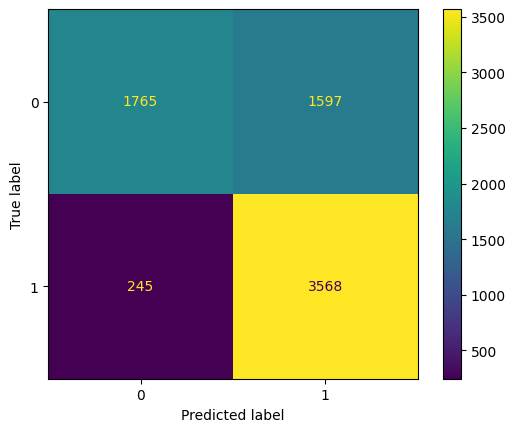

In [95]:
train_disp.plot()

In [96]:
ytest = np.round(ytest).astype(int)
ytest.shape

(3076, 2)

In [97]:
yhat_test.shape

(3076, 2)

In [98]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [99]:
ytest_single = np.argmax(ytest, axis=1)

In [100]:
yhat_test_single.shape

(3076,)

In [101]:
ytest_single.shape

(3076,)

In [102]:
test_cm = confusion_matrix(ytest_single, yhat_test_single)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)



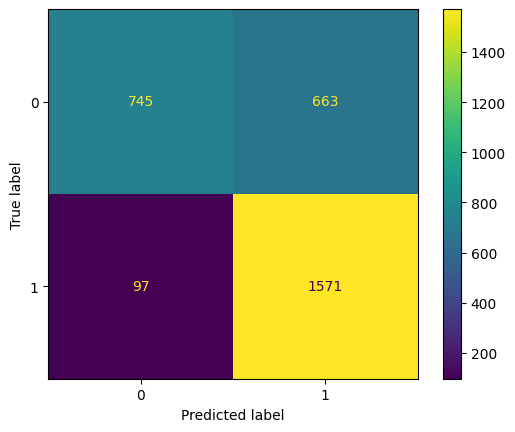

In [103]:
test_disp.plot()

In [104]:
##use pyMAISE one

In [105]:
xtrain.shape

(7175, 10, 14)